In [1]:

# === Common Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make plots a bit larger
plt.rcParams["figure.figsize"] = (6,4)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error,
                             accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_curve, auc, jaccard_score)
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA

# Optional: SciPy for dendrogram (only used if available)
try:
    from scipy.cluster.hierarchy import dendrogram, linkage
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

import os

RANDOM_STATE = 42

# === Small helpers ===
def ensure_csv_or_make(df, fname):
    # If fname exists, return pd.read_csv(fname); else save df to fname then read+return.
    if os.path.exists(fname):
        return pd.read_csv(fname)
    else:
        df.to_csv(fname, index=False)
        return df

def plot_actual_vs_pred(y_true, y_pred, title="Actual vs Predicted"):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.7)
    mn = min(y_true.min(), y_pred.min())
    mx = max(y_true.max(), y_pred.max())
    plt.plot([mn, mx], [mn, mx])
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.show()

def print_regression_metrics(y_true, y_pred):
    print("R2:", r2_score(y_true, y_pred))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", mean_squared_error(y_true, y_pred, squared=False))

def plot_confusion_matrix_basic(cm, class_names=None, title="Confusion Matrix"):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    import numpy as _np
    tick_marks = _np.arange(cm.shape[0])
    if class_names is None:
        class_names = [str(i) for i in range(cm.shape[0])]
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


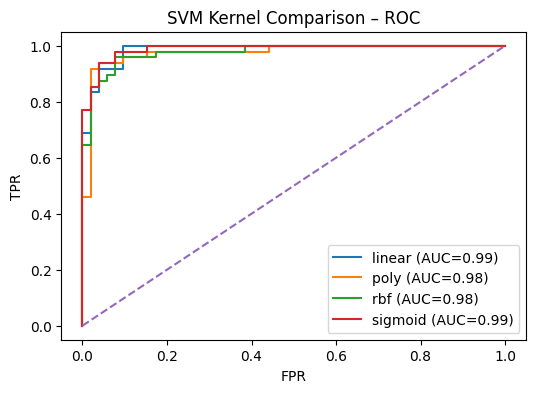


=== LINEAR ===
Accuracy: 0.93
Recall: 0.9583333333333334
Precision: 0.9019607843137255
F1-Score: 0.9292929292929293
Jaccard: 0.8679245283018868
Error rate: 0.06999999999999995


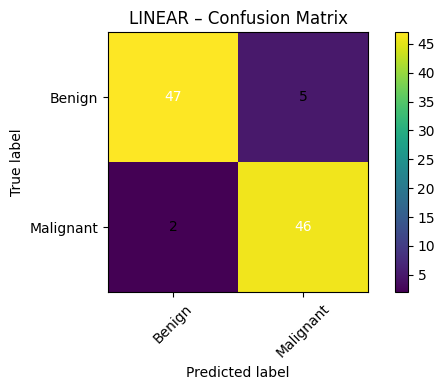


=== POLY ===
Accuracy: 0.9
Recall: 0.9583333333333334
Precision: 0.8518518518518519
F1-Score: 0.9019607843137255
Jaccard: 0.8214285714285714
Error rate: 0.09999999999999998


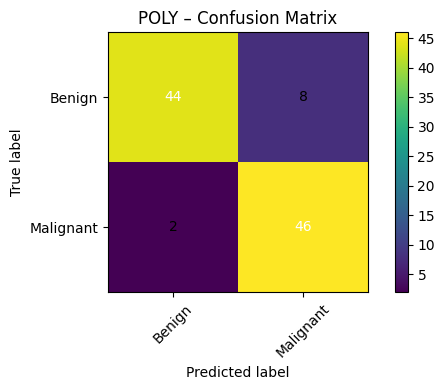


=== RBF ===
Accuracy: 0.93
Recall: 0.9583333333333334
Precision: 0.9019607843137255
F1-Score: 0.9292929292929293
Jaccard: 0.8679245283018868
Error rate: 0.06999999999999995


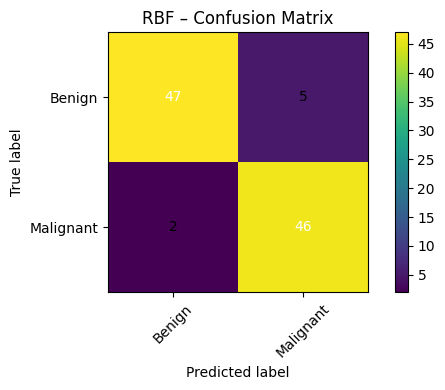


=== SIGMOID ===
Accuracy: 0.95
Recall: 0.9791666666666666
Precision: 0.9215686274509803
F1-Score: 0.9494949494949495
Jaccard: 0.9038461538461539
Error rate: 0.050000000000000044


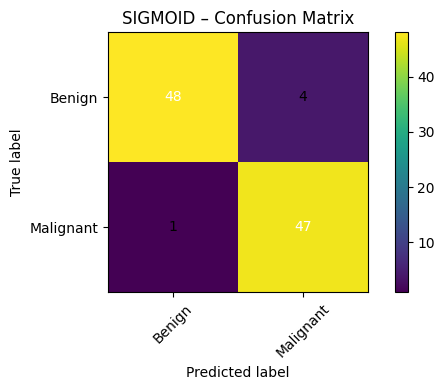

In [2]:

fname = "samples_cancer.csv"
data = pd.read_csv(fname)
ycol = "target" if "target" in data.columns else data.columns[-1]
X = data.drop(columns=[ycol]).values
y = data[ycol].values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

kernels = {
    "linear": {"kernel":"linear", "probability":True},
    "poly":   {"kernel":"poly", "degree":3, "probability":True},
    "rbf":    {"kernel":"rbf", "probability":True},
    "sigmoid":{"kernel":"sigmoid", "probability":True}
}

results = {}

plt.figure()
for name, params in kernels.items():
    clf = SVC(**params, random_state=RANDOM_STATE)
    clf.fit(X_train_s, y_train)
    pred = clf.predict(X_test_s)
    proba = clf.predict_proba(X_test_s)[:,1]

    acc = accuracy_score(y_test, pred)
    rec = recall_score(y_test, pred)
    prec = precision_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    jac = jaccard_score(y_test, pred)
    err = 1 - acc
    cm = confusion_matrix(y_test, pred)

    results[name] = {"acc":acc, "rec":rec, "prec":prec, "f1":f1, "jaccard":jac, "error":err, "cm":cm}

    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1], linestyle="--")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("SVM Kernel Comparison – ROC")
plt.show()

for name, d in results.items():
    print(f"\n=== {name.upper()} ===")
    print("Accuracy:", d["acc"])
    print("Recall:", d["rec"])
    print("Precision:", d["prec"])
    print("F1-Score:", d["f1"])
    print("Jaccard:", d["jaccard"])
    print("Error rate:", d["error"])
    plot_confusion_matrix_basic(d["cm"], class_names=["Benign","Malignant"], title=f"{name.upper()} – Confusion Matrix")
